# NER

In this excercise we will explore Named Entities Recognition task. 

Imagine that you need to extract some specific information from your texts. First you might want to check how existing models manage to solve this task on your data. To this end you will analyze the performance of pretrained NER model on a dataset using the tools of [Transformers](https://huggingface.co/docs/transformers/index) library by huggingface that is one of the most common packages for working with NLP models.  

You can follow this [tutorial](https://huggingface.co/learn/nlp-course/chapter7/2?fw=pt) to get ideas and extra information.

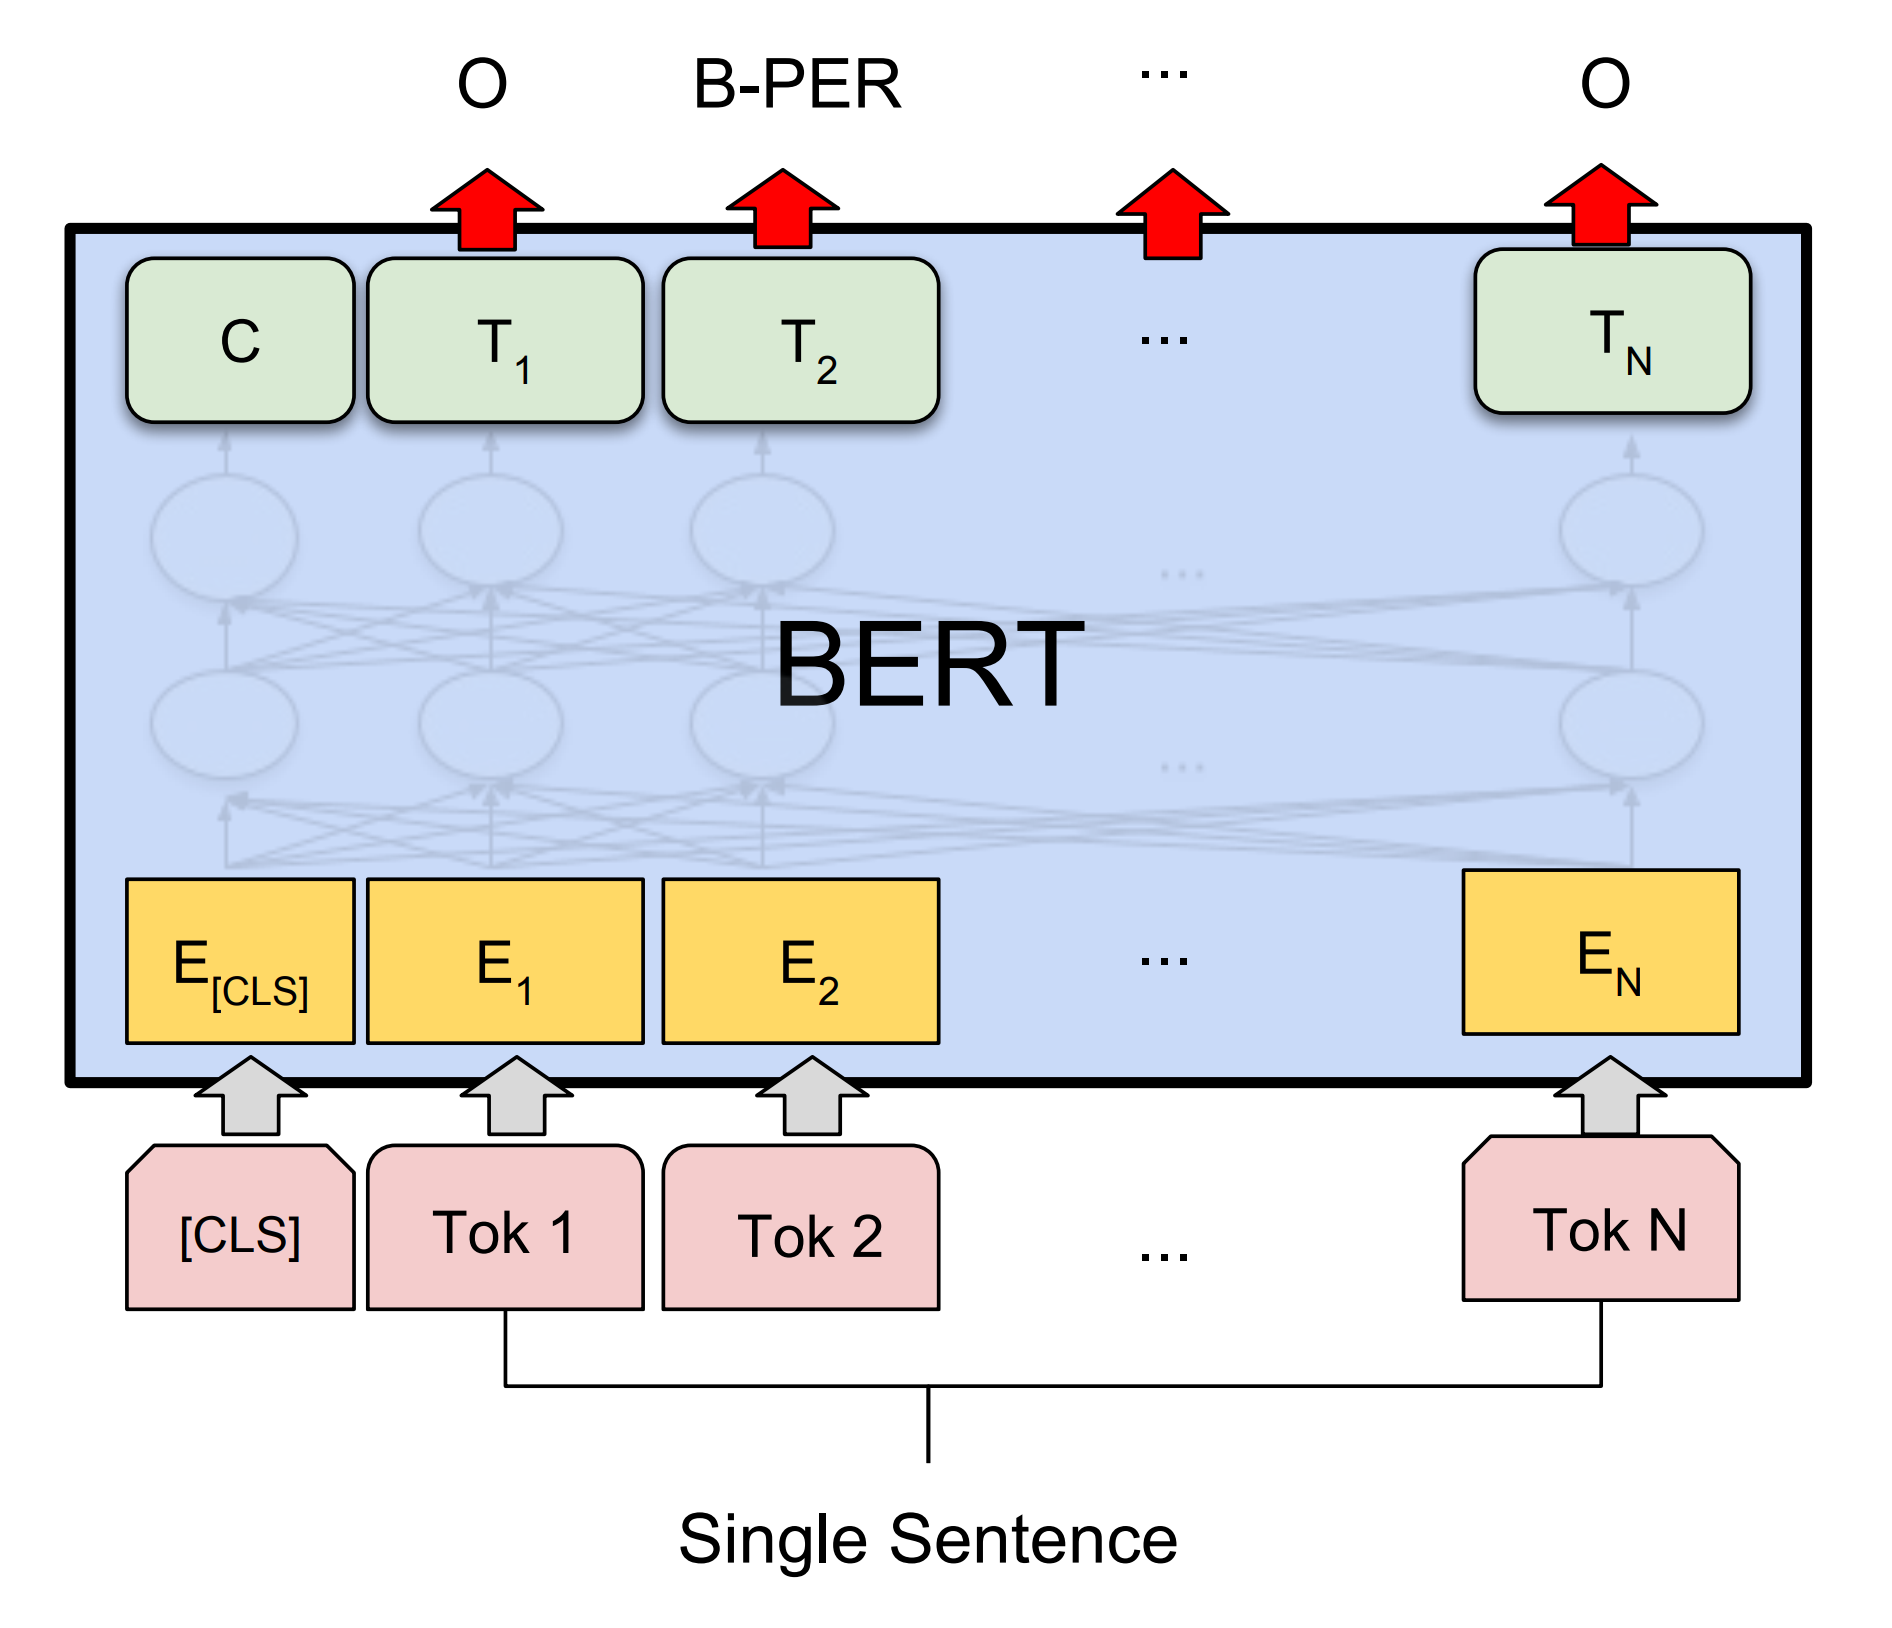

## Install and import libraries

In [1]:
!pip install transformers==4.28.0 datasets evaluate seqeval

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 61.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 52.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 124.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 65.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 

In [2]:
import numpy as np
import torch


from datasets import load_dataset
import evaluate
from transformers import AutoTokenizer
from transformers import DataCollatorForTokenClassification
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import pipeline
import pandas as pd

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Dataset



[Datasets](https://github.com/huggingface/datasets) library allows to load  popular datasets for various ML tasks. We'll use dataset Wikiann containing Wikipedia texts for different lanuages labeled with named entities.

In [3]:
ds = load_dataset("wikiann", "en")

Generating validation split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Generating train split:   0%|          | 0/20000 [00:00<?, ? examples/s]

Dataset wikiann downloaded and prepared to /root/.cache/huggingface/datasets/wikiann/en/1.1.0/4bfd4fe4468ab78bb6e096968f61fab7a888f44f9d3371c2f3fea7e74a5a354e. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

Dataset is split into train, test and validation subsets. Data contains tokens, NER tags, language indicator and NER spans.   

In [4]:
ds

DatasetDict({
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 10000
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 10000
    })
    train: Dataset({
        features: ['tokens', 'ner_tags', 'langs', 'spans'],
        num_rows: 20000
    })
})

To access single sample we should select subset and sample index.
Print some examples from the dataset. 

In [5]:
# create single dataset

dataframes = []
for split_name, dataset in ds.items():
    df = pd.DataFrame(dataset)
    df['split'] = split_name
    dataframes.append(df)

# Concatenate the dataframes into a single dataframe
concatenated_df = pd.concat(dataframes, ignore_index=True)
concatenated_df

,tokens,ner_tags,langs,spans,split
0,"[Sioux, Falls, Arena, (, Sioux, Falls, ,, Sout...","[3, 4, 4, 0, 5, 6, 6, 6, 6, 0]","[en, en, en, en, en, en, en, en, en, en]","[ORG: Sioux Falls Arena, LOC: Sioux Falls , So...",validation
1,"[George, Randolph, Hearst, ,, Jr, .]","[1, 2, 2, 2, 2, 2]","[en, en, en, en, en, en]","[PER: George Randolph Hearst , Jr .]",validation
2,"[Conch, Key, ,, Florida]","[5, 6, 6, 6]","[en, en, en, en]","[LOC: Conch Key , Florida]",validation
3,"[Fairground]], '', by, Simply, Red, '', Bad, R...","[0, 0, 0, 3, 4, 0, 3, 4, 0, 0, 1, 2]","[en, en, en, en, en, en, en, en, en, en, en, en]","[ORG: Simply Red, ORG: Bad Romance, PER: Lady ...",validation
4,"[The, Game]], ,, Ice, Cube, ,, Dr., Dre]","[0, 0, 0, 1, 2, 0, 1, 2]","[en, en, en, en, en, en, en, en]","[PER: Ice Cube, PER: Dr. Dre]",validation
...,...,...,...,...,...
39995,"[Cicely, Courtneidge, ,, Ernest, Truex]","[1, 2, 0, 1, 2]","[en, en, en, en, en]","[PER: Cicely Courtneidge, PER: Ernest Truex]",train
39996,"[Aracaju, ,, Sergipe, ,, Brazil]","[5, 0, 5, 0, 5]","[en, en, en, en, en]","[LOC: Aracaju, LOC: Sergipe, LOC: Brazil]",train
39997,"[Louisville, in, the, American, Civil, War]","[5, 6, 6, 6, 6, 6]","[en, en, en, en, en, en]",[LOC: Louisville in the American Civil War],train
39998,"[16, (, David, Nugent, )]","[0, 0, 1, 2, 0]","[en, en, en, en, en]",[PER: David Nugent],train


In [6]:
for index, sample in concatenated_df.iloc[0:5].iterrows():
  print(f" Tokens: {sample['tokens']}\n NER_TAGS: {sample['ner_tags']}\n Spans: {sample['spans']} \n")
  

 Tokens: ['Sioux', 'Falls', 'Arena', '(', 'Sioux', 'Falls', ',', 'South', 'Dakota', ')']
 NER_TAGS: [3, 4, 4, 0, 5, 6, 6, 6, 6, 0]
 Spans: ['ORG: Sioux Falls Arena', 'LOC: Sioux Falls , South Dakota'] 

 Tokens: ['George', 'Randolph', 'Hearst', ',', 'Jr', '.']
 NER_TAGS: [1, 2, 2, 2, 2, 2]
 Spans: ['PER: George Randolph Hearst , Jr .'] 

 Tokens: ['Conch', 'Key', ',', 'Florida']
 NER_TAGS: [5, 6, 6, 6]
 Spans: ['LOC: Conch Key , Florida'] 

 Tokens: ['Fairground]]', "''", 'by', 'Simply', 'Red', "''", 'Bad', 'Romance', "''", 'by', 'Lady', 'Gaga']
 NER_TAGS: [0, 0, 0, 3, 4, 0, 3, 4, 0, 0, 1, 2]
 Spans: ['ORG: Simply Red', 'ORG: Bad Romance', 'PER: Lady Gaga'] 

 Tokens: ['The', 'Game]]', ',', 'Ice', 'Cube', ',', 'Dr.', 'Dre']
 NER_TAGS: [0, 0, 0, 1, 2, 0, 1, 2]
 Spans: ['PER: Ice Cube', 'PER: Dr. Dre'] 



Field *tokens* contains input sentences split into words. Field *ner_tags* contains ids of NER markup tags in BIO format, first token of each entitiy is marked with B-prefix, inside tokens are marked with I-prefix, tokens that do not belong to any of named entities are labeled with O tag.  

Which entities are presented in the dataset?
Let's have a look at the names of all NER tags the dataset include.

In [7]:
import itertools

all_entities = list(itertools.chain(*concatenated_df['spans'].values))

print(f'Number of entities: {len(all_entities)}')
print(f'Number of unique entities: {len(set(all_entities))}')
set(all_entities)

Number of entities: 56035
Number of unique entities: 46513


{'LOC: Jakarta',
 'LOC: Pacific Junction , Iowa',
 'ORG: Territorial Defence of Bosnia and Herzegovina',
 'PER: Anne Marie Carl-Nielsen',
 'PER: Carrera Damas , Germán',
 'PER: Carmen McRae',
 'ORG: Neel',
 'LOC: Manaus',
 'LOC: Wildlife sanctuaries of India',
 'PER: Sarah Palin',
 'ORG: Opposites Attract',
 'ORG: Cedar Rapids Canaries',
 'PER: Teodor-Dacian Crăciun',
 'ORG: High bit rate audio video over Internet Protocol',
 'ORG: The Sunny South',
 "ORG: Ca n't Say No",
 'ORG: San Antonio Spurs',
 'ORG: National Labor Relations Board',
 'PER: Juris Šics',
 'LOC: Happy Valley Tianjin',
 'LOC: Trzęsacz , Choszczno County',
 'LOC: Rajasthan',
 'ORG: FC Wil',
 'PER: Atanatar I',
 'PER: Raimund von zur-Mühlen',
 'PER: Mary Donohue',
 'LOC: Sindbis virus',
 'LOC: Heliura rhodocryptoides',
 'LOC: Kensington',
 'PER: Mike Emrick',
 'ORG: Government Ayurveda Medical College',
 'PER: Helga Niessen Masthoff',
 'PER: Craig Wiseman',
 'LOC: Siah Piran-e Kasmai',
 'ORG: Hong Kong legislative elect

Create dictionaries to map tag ids (stored in the field ner_tags) to the names of the tags.

In [8]:
from collections import defaultdict

tag_to_names_dict = defaultdict(list)

for index, sample in concatenated_df.iterrows():
  non_zero_elements = np.nonzero(sample['ner_tags'])[0]

  for element in non_zero_elements:
    tag = sample['ner_tags'][element]
    name = sample['tokens'][element]
    tag_to_names_dict[tag].append(name)


tag_to_names_dict.keys()

dict_keys([3, 4, 5, 6, 1, 2])

In [9]:
tag_to_names_dict

defaultdict(list,
            {3: ['Sioux',
              'Simply',
              'Bad',
              'Zina',
              'Almere',
              'Chiangrai',
              'Fireball',
              'Sringeri',
              'Parodius',
              'River',
              'Kalamazoo',
              'It',
              'D36',
              'National',
              'Melbourne',
              'Vila',
              'IUCN',
              'U.S',
              'Ministry',
              'Carthay',
              'Diocese',
              'Conference',
              'Newport',
              'division',
              'Woh',
              'Sarawak',
              'FC',
              'FC',
              'FC',
              'Follin',
              'San‘a’',
              'Wolf',
              'Exo',
              'List',
              'The',
              'Marina',
              'St',
              'Oxford',
              'National',
              'Association',
              'National',
       

How many examples does the dataset contain for each of the entity types?

In [10]:
entity_types_size = {key: len(value) for key, value in tag_to_names_dict.items()}
entity_types_size


{3: 18844, 4: 46471, 5: 18836, 6: 25981, 1: 18355, 2: 29698}

## Preprocessing

Transformer-based models use Byte-Pair Encoding (BPE) tokenization that splits texts into tokens (words or subwords) according to their occurence in training corpus. So to apply the model we need to preprocess input sentences using tokenizer built during the training of the model.

In this exercise we will use [NER BERT model](https://huggingface.co/dslim/bert-base-NER) trained on CoNLL-2003 dataset. The model was trained for NER task with entity types contained in our dataset so we can use it to predict names entities for texts in our dataset.

In [11]:
model_name = 'dslim/bert-base-NER'

We will initialize tokenizer using AutoTokenizer.

In [12]:
from transformers import AutoTokenizer
    
tokenizer = AutoTokenizer.from_pretrained(model_name)

Print some examples of tokenized texts from the dataset we are working with (Wikiann).

In [13]:
texts = concatenated_df.iloc[0:5]['tokens'].apply(lambda x: " ".join(x))

for text in texts:
  tokens = tokenizer.tokenize(text.strip())
  print(f" Text: {text}\n Tokens: {tokens}\n")

 Text: Sioux Falls Arena ( Sioux Falls , South Dakota )
 Tokens: ['Sioux', 'Falls', 'Arena', '(', 'Sioux', 'Falls', ',', 'South', 'Dakota', ')']

 Text: George Randolph Hearst , Jr .
 Tokens: ['George', 'Randolph', 'Hear', '##st', ',', 'Jr', '.']

 Text: Conch Key , Florida
 Tokens: ['Con', '##ch', 'Key', ',', 'Florida']

 Text: Fairground]] '' by Simply Red '' Bad Romance '' by Lady Gaga
 Tokens: ['Fair', '##ground', ']', ']', "'", "'", 'by', 'Si', '##mp', '##ly', 'Red', "'", "'", 'Bad', 'Romance', "'", "'", 'by', 'Lady', 'Gaga']

 Text: The Game]] , Ice Cube , Dr. Dre
 Tokens: ['The', 'Game', ']', ']', ',', 'Ice', 'C', '##ube', ',', 'Dr', '.', 'Dr', '##e']



Tokenizer output contains *input_ids* -- ids of tokens in model's vocabulary and *attention_mask* -- list of numbers 1 or 0 where 1 corresponds to tokens from input and 0 corresponds to padding special tokens [*PAD*]. 

As we can see new tokens do not match original tokenization of the dataset (in the dataset sentences were split into words) which means that we need to align NER labels from the dataset with BERT tokenized sentences. 
There are different way for creating NER markup with subword tokenization, here we will the following strategy:
* Assign entitity tag only for the starting subtoken of the word
* Tag all inner subtokens with special label -100 because this index is ignored in loss function calculation. 
* Mark special tokens ([CLS], [SEP], [PAD], [UNK]) with -100 label.


For example,

    Initial markup: Johnson(B-Person) 

    Markup after tokenization: [CLS](-100) - John(B-Person) - ##son(-100)
 

Create a function that assigns entity label to the first subtoken within this entity and label -100 for all the rest subtokens of the entity and special tokens. 

Tokenize dataset texts and create new labels using this function.  

In [14]:
from functools import lru_cache

@lru_cache(maxsize=10000)
def get_word_tags(word, tag):
  bert_tokens = tokenizer.tokenize(word)
  word_tags = np.ones_like(bert_tokens, dtype=float) * (-100)
  word_tags[0] = tag
  return list(word_tags)

def map_between_sample_to_ner_tags(sample):
  # initilize with -100 for CLS toekn
  sample_tags = [[-100]]
  for index, token in enumerate(sample['tokens']):
    bert_ner_tags= get_word_tags(token, sample['ner_tags'][index])
    sample_tags.append(bert_ner_tags)
  # add separeator token 
  sample_tags.append([-100])
  sample_tags = list(itertools.chain(*sample_tags))
  return sample_tags

concatenated_df['ner_labels'] = concatenated_df.apply(lambda x: map_between_sample_to_ner_tags(x), axis=1)
concatenated_df['ner_labels']

0        [-100, 3.0, 4.0, 4.0, 0.0, 5.0, 6.0, 6.0, 6.0,...
1        [-100, 1.0, 2.0, 2.0, -100.0, 2.0, 2.0, 2.0, -...
2                 [-100, 5.0, -100.0, 6.0, 6.0, 6.0, -100]
3        [-100, 0.0, -100.0, -100.0, -100.0, 0.0, -100....
4        [-100, 0.0, 0.0, -100.0, -100.0, 0.0, 1.0, 2.0...
                               ...                        
39995    [-100, 1.0, -100.0, -100.0, 2.0, -100.0, -100....
39996    [-100, 5.0, -100.0, -100.0, 0.0, 5.0, -100.0, ...
39997           [-100, 5.0, 6.0, 6.0, 6.0, 6.0, 6.0, -100]
39998    [-100, 0.0, 0.0, 1.0, 2.0, -100.0, -100.0, 0.0...
39999                [-100, 3.0, 4.0, 4.0, 4.0, 4.0, -100]
Name: ner_labels, Length: 40000, dtype: object

## Model Predictions Analysis

Now let's load pretrained model for token classification to see how it works on our dataset.

In [15]:
from transformers import AutoModelForTokenClassification
model = AutoModelForTokenClassification.from_pretrained(model_name)

In [16]:
model

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [17]:
model.num_labels

9

In [18]:
model.config

BertConfig {
  "_name_or_path": "dslim/bert-base-NER",
  "_num_labels": 9,
  "architectures": [
    "BertForTokenClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "O",
    "1": "B-MISC",
    "2": "I-MISC",
    "3": "B-PER",
    "4": "I-PER",
    "5": "B-ORG",
    "6": "I-ORG",
    "7": "B-LOC",
    "8": "I-LOC"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "B-LOC": 7,
    "B-MISC": 1,
    "B-ORG": 5,
    "B-PER": 3,
    "I-LOC": 8,
    "I-MISC": 2,
    "I-ORG": 6,
    "I-PER": 4,
    "O": 0
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.28.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size"

Check model's performance on several examples from the dataset:
* Tokenize input text
* Run model using input_ids and attention_mask from tokenized input
* Get predicted NER labels for model's output using id2label from the config of the model.

Get the predictions for the sample of 100 examples from the test subset.

In [19]:
DATA_LABEL_MAPPING = {
    0: "O",
    1: "B-PER",
    2: "I-PER",
    3: "B-ORG",
    4: "I-ORG",
    5: "B-LOC",
    6: "I-LOC"
}

MODEL_LABEL_MAPPING = model.config.id2label
MODEL_LABEL_MAPPING

{0: 'O',
 1: 'B-MISC',
 2: 'I-MISC',
 3: 'B-PER',
 4: 'I-PER',
 5: 'B-ORG',
 6: 'I-ORG',
 7: 'B-LOC',
 8: 'I-LOC'}

In [20]:
def map_labels_predictions(predictions, labels, mapper_prediction, mapper_labels):
  predictions_mapped = []
  labels_mapped = []
  for index, token_label in enumerate(labels):
    if token_label == -100:
      continue
    token_label = mapper_labels[token_label]
    prediction = mapper_prediction[predictions[index].item()]
    predictions_mapped.append(prediction)
    labels_mapped.append(token_label)
  
  return predictions_mapped, labels_mapped

def predict_sample(sample, mapper_prediction=None, mapper_labels=None):
  sample_text = " ".join(sample['tokens'])
  encoding = tokenizer.encode_plus(sample_text,
                                    add_special_tokens=True, # adding '[CLS]' and '[SEP]' tokens
                                    return_token_type_ids=False,
                                    return_attention_mask=True,
                                    return_tensors='pt', 
                                  )
  model.eval()  # Set the model to evaluation mode
  with torch.no_grad():
      outputs = model(encoding['input_ids'], attention_mask=encoding['attention_mask'])

  predictions = outputs.logits.argmax(dim=2)[0]
  labels = sample['ner_labels']
  if mapper_labels is not None and mapper_prediction is not None:
    predictions, labels = map_labels_predictions(predictions, labels, mapper_prediction, mapper_labels)
  else:
    mask = np.where(np.array(labels) >=0 )
    labels = np.array(labels)[mask]
    predictions = predictions.numpy()[mask]
  return predictions, labels

test_samples = concatenated_df[concatenated_df['split'] == 'test']
test_samples = test_samples.iloc[0:100]

test_samples[['prediction', 'label']] = test_samples.apply(lambda x: predict_sample(x,MODEL_LABEL_MAPPING, DATA_LABEL_MAPPING), axis=1, result_type='expand')

test_samples

,tokens,ner_tags,langs,spans,split,ner_labels,prediction,label
10000,"[Shortly, afterward, ,, an, encouraging, respo...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, ...","[en, en, en, en, en, en, en, en, en, en, en, e...","[LOC: India, LOC: Adyar]",test,"[-100, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[O, O, O, O, O, O, O, O, O, O, O, B-LOC, O, O,...","[O, O, O, O, O, O, O, O, O, O, O, B-LOC, O, O,..."
10001,"[:, Kanye, West, featuring, Jamie, Foxx, —, ``...","[0, 1, 2, 0, 1, 2, 0, 0, 3, 4, 0, 0, 0, 0]","[en, en, en, en, en, en, en, en, en, en, en, e...","[PER: Kanye West, PER: Jamie Foxx, ORG: Gold D...",test,"[-100, 0.0, 1.0, -100.0, -100.0, 2.0, 0.0, 1.0...","[O, B-PER, I-PER, O, B-PER, I-PER, O, O, B-MIS...","[O, B-PER, I-PER, O, B-PER, I-PER, O, O, B-ORG..."
10002,"[Blacktown, railway, station]","[3, 4, 4]","[en, en, en]",[ORG: Blacktown railway station],test,"[-100, 3.0, -100.0, 4.0, 4.0, -100]","[B-LOC, O, O]","[B-ORG, I-ORG, I-ORG]"
10003,"['', Mycalesis, perseus, lalassis, '', (, Hewi...","[0, 5, 6, 6, 0, 0, 0, 0, 0, 0]","[en, en, en, en, en, en, en, en, en, en]",[LOC: Mycalesis perseus lalassis],test,"[-100, 0.0, -100.0, 5.0, -100.0, -100.0, 6.0, ...","[O, B-MISC, O, O, O, O, B-PER, O, O, O]","[O, B-LOC, I-LOC, I-LOC, O, O, O, O, O, O]"
10004,"[Jonny, Lee, Miller, -, Eli, Stone, '']","[1, 2, 2, 0, 3, 4, 0]","[en, en, en, en, en, en, en]","[PER: Jonny Lee Miller, ORG: Eli Stone]",test,"[-100, 1.0, -100.0, 2.0, 2.0, 0.0, 3.0, 4.0, 0...","[B-PER, I-PER, I-PER, O, B-PER, I-PER, O]","[B-PER, I-PER, I-PER, O, B-ORG, I-ORG, O]"
...,...,...,...,...,...,...,...,...
10095,"[**, ``, Back, for, More, '', –, Sandwich]","[0, 0, 0, 0, 0, 0, 0, 3]","[en, en, en, en, en, en, en, en]",[ORG: Sandwich],test,"[-100, 0.0, -100.0, 0.0, -100.0, 0.0, 0.0, 0.0...","[O, O, O, O, O, O, O, B-LOC]","[O, O, O, O, O, O, O, B-ORG]"
10096,"[Crested, caracara, ,, ''Caracara, cheriway, '...","[3, 4, 0, 0, 0, 0, 0, 0, 0]","[en, en, en, en, en, en, en, en, en]",[ORG: Crested caracara],test,"[-100, 3.0, -100.0, -100.0, 4.0, -100.0, -100....","[O, O, O, O, O, O, O, O, O]","[B-ORG, I-ORG, O, O, O, O, O, O, O]"
10097,"[8, July, —, Annie, Shepherd, Swan, ,, writer,...","[0, 0, 0, 1, 2, 2, 0, 0, 0, 0, 0, 0]","[en, en, en, en, en, en, en, en, en, en, en, en]",[PER: Annie Shepherd Swan],test,"[-100, 0.0, 0.0, 0.0, 1.0, 2.0, 2.0, 0.0, 0.0,...","[O, O, O, B-PER, I-PER, I-PER, O, O, O, O, O, O]","[O, O, O, B-PER, I-PER, I-PER, O, O, O, O, O, O]"
10098,"[Vandino, and, Ugolino, Vivaldi]","[1, 2, 2, 2]","[en, en, en, en]",[PER: Vandino and Ugolino Vivaldi],test,"[-100, 1.0, -100.0, -100.0, 2.0, 2.0, -100.0, ...","[B-PER, O, B-PER, I-PER]","[B-PER, I-PER, I-PER, I-PER]"


In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pprint import pprint

seqeval = evaluate.load("seqeval")

pprint(seqeval.compute(references=test_samples['label'].values
                                      ,predictions=test_samples['prediction'].values))


{'LOC': {'f1': 0.37894736842105264,
         'number': 39,
         'precision': 0.32142857142857145,
         'recall': 0.46153846153846156},
 'MISC': {'f1': 0.0, 'number': 0, 'precision': 0.0, 'recall': 0.0},
 'ORG': {'f1': 0.40909090909090917,
         'number': 56,
         'precision': 0.5625,
         'recall': 0.32142857142857145},
 'PER': {'f1': 0.8200836820083682,
         'number': 113,
         'precision': 0.7777777777777778,
         'recall': 0.8672566371681416},
 'overall_accuracy': 0.8196864111498258,
 'overall_f1': 0.6090909090909091,
 'overall_precision': 0.5775862068965517,
 'overall_recall': 0.6442307692307693}


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


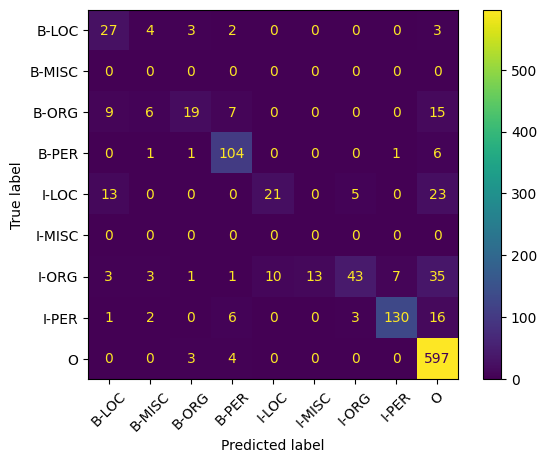

In [22]:
import matplotlib.pyplot as plt

predictions = list(itertools.chain(*test_samples['prediction'].values))
labels = list(itertools.chain(*test_samples['label'].values))

cm = confusion_matrix(y_true=labels, y_pred=predictions)
cmd = ConfusionMatrixDisplay(cm, display_labels=sorted(MODEL_LABEL_MAPPING.values()))
cmd.plot()
plt.xticks(rotation=45);

Let's take a look at incorrect predictions. 

Analyze the model's output, which entities were predicted incorrectly, can you see some patterns? 
Note that the dataset is labeled for three types of entites (PER, LOC, ORG) while the model also predicts extra type (MISC).

Test the model on your own examples and describe the result.

We can see that the model has difficulties to classify Organization and locations. The model is much better in recognize persons & objects that don't belong to any specific label ("O"), the model has a tendency to predict "O" in many of the errors, specially for Organization and I-LOC.

The model also predict MISC that is not in our dataset.

## Evaluation

The model was trained on CONLL-2003 dataset. We will evaluate model's performance on the test subset of this dataset. 

Write code to evaluate the model:
* Load CONLL-2003 dataset
* Tokenize input texts and align NER tags markup
* Run the model to get predictions for test set
* Compute metrics using [seqeval](https://huggingface.co/spaces/evaluate-metric/seqeval) module of evaluate library (for evaluation we should ignore all non-starting subtokens within a word and special tokens).


In [23]:
seqeval = evaluate.load("seqeval")


In [24]:
get_word_tags.cache_clear()

conll_dataset =  load_dataset("conll2003")
conll_dataset_test = pd.DataFrame(conll_dataset['test'])
conll_dataset_test['ner_labels'] = conll_dataset_test.apply(lambda x: map_between_sample_to_ner_tags(x), axis=1)

Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

Dataset conll2003 downloaded and prepared to /root/.cache/huggingface/datasets/conll2003/conll2003/1.0.0/9a4d16a94f8674ba3466315300359b0acd891b68b6c8743ddf60b9c702adce98. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [25]:
CONLL_LABEL_MAPPING = {0: 'O',  1:'B-PER', 2:'I-PER', 3:'B-ORG', 4:'I-ORG', 5: 'B-LOC', 6: 'I-LOC', 7: 'B-MISC', 8: 'I-MISC'}

In [26]:
conll_dataset_test[['prediction', 'label']] = conll_dataset_test.apply(lambda x: predict_sample(x, MODEL_LABEL_MAPPING, CONLL_LABEL_MAPPING), axis=1, result_type='expand')
conll_dataset_test[['prediction', 'label']]



,prediction,label
0,"[O, O, B-MISC, O, B-PER, O, O, B-ORG, O, O, O, O]","[O, O, B-LOC, O, O, O, O, B-PER, O, O, O, O]"
1,"[B-PER, I-PER]","[B-PER, I-PER]"
2,"[B-LOC, O, B-LOC, I-LOC, I-LOC, O]","[B-LOC, O, B-LOC, I-LOC, I-LOC, O]"
3,"[B-LOC, O, O, O, O, O, B-MISC, I-MISC, O, O, O...","[B-LOC, O, O, O, O, O, B-MISC, I-MISC, O, O, O..."
4,"[O, B-LOC, O, O, O, O, O, O, O, O, O, O, O, O,...","[O, B-LOC, O, O, O, O, O, O, O, O, O, O, O, O,..."
...,...,...
3448,"[O, O, O, O, O, O, O, O, O, O, O, O, O, B-PER,...","[O, O, O, O, O, O, O, O, O, O, O, O, O, B-PER,..."
3449,"[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ..."
3450,"[B-PER, O, B-LOC, O, O, O, O, O, O, O, O, O, O...","[B-PER, O, B-LOC, O, O, O, O, O, O, O, O, O, O..."
3451,"[O, O, B-LOC, O, O, O, B-MISC, I-MISC, O, O, O...","[O, O, B-LOC, O, O, O, B-MISC, I-MISC, O, O, O..."


In [27]:
results = seqeval.compute(references=conll_dataset_test['label'].values
                                      ,predictions=conll_dataset_test['prediction'].values)

pprint(results)

{'LOC': {'f1': 0.9306514560192134,
         'number': 1668,
         'precision': 0.9320505111244738,
         'recall': 0.9292565947242206},
 'MISC': {'f1': 0.8041522491349481,
          'number': 702,
          'precision': 0.7819650067294751,
          'recall': 0.8276353276353277},
 'ORG': {'f1': 0.89925705794948,
         'number': 1661,
         'precision': 0.8879107981220657,
         'recall': 0.9108970499698976},
 'PER': {'f1': 0.9573283858998145,
         'number': 1617,
         'precision': 0.9573283858998145,
         'recall': 0.9573283858998145},
 'overall_accuracy': 0.9825347259610208,
 'overall_f1': 0.9128791208791208,
 'overall_precision': 0.9065828531517374,
 'overall_recall': 0.9192634560906515}


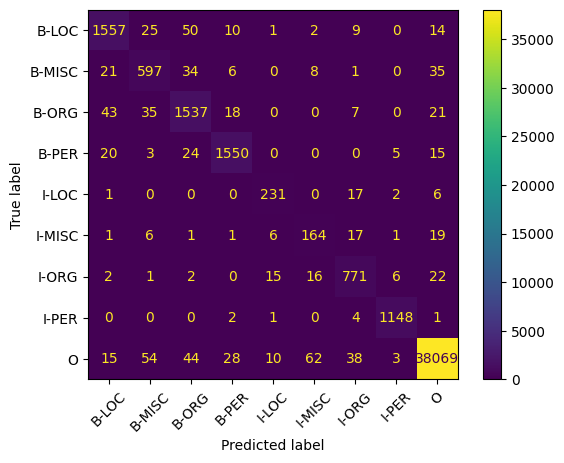

In [28]:
import matplotlib.pyplot as plt

cornll_predictions = list(itertools.chain(*conll_dataset_test['prediction'].values))
cornll_labels = list(itertools.chain(*conll_dataset_test['label'].values))
cm = confusion_matrix(y_true=cornll_labels, y_pred=cornll_predictions)
cmd = ConfusionMatrixDisplay(cm, display_labels=sorted(MODEL_LABEL_MAPPING.values()))
cmd.plot()
plt.xticks(rotation=45);

## Bonus: Fine-tuning
If you want to dive deeper in NER task, try to fine-tune base BERT model on Wikiann dataset following the tutorial. 

In [29]:
!pip install --upgrade accelerate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 6.5 MB/s eta 0:00:00


In [30]:
from torch.utils.data import Dataset, DataLoader

class ReviewDataset(Dataset):

  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  
  def __len__(self):
    return len(self.reviews)
  
  def __getitem__(self, item):
    review = str(' '.join(self.reviews[item]))
    target = np.array([self.targets[item]]).flatten()
    if len(target) >=self.max_len:
      target = target[: self.max_len]
    else:
      target = np.pad(target, (0, self.max_len - len(target)), constant_values=0)
    target = np.where(target > 0, target, 0)
    encoding = self.tokenizer(
      review,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      truncation=True,
      return_tensors='pt',
    )
    return {
      'text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'labels': torch.tensor(target, dtype=torch.long)
    }


In [31]:
MAX_LEN = 128

train_ds = concatenated_df[concatenated_df['split'] == 'train']
val_ds =  concatenated_df[concatenated_df['split'] == 'validation']
test_ds =  concatenated_df[concatenated_df['split'] == 'test']

train_ds = ReviewDataset(
    reviews=train_ds['tokens'].values,
    targets=train_ds['ner_labels'].values,
    tokenizer=tokenizer,
    max_len=MAX_LEN
  )

val_ds = ReviewDataset(
    reviews=val_ds['tokens'].values,
    targets=val_ds['ner_labels'].values,
    tokenizer=tokenizer,
    max_len=MAX_LEN
  )

test_ds = ReviewDataset(
    reviews=test_ds['tokens'].values,
    targets=test_ds['ner_labels'].values,
    tokenizer=tokenizer,
    max_len=MAX_LEN
  )

In [32]:
model = AutoModelForTokenClassification.from_pretrained(model_name)

config = model.config
config.num_labels = 7

model.config = config

model.save_pretrained("new_model")

model.to(device)

BertForTokenClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, el

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    preds = preds.reshape(preds.shape[0] * preds.shape[1])
    labels = labels.reshape(labels.shape[0] * labels.shape[1])
    return {
        'accuracy': accuracy_score(labels, preds),
        'f1': f1_score(labels, preds, average='weighted'),
        'precision': precision_score(labels, preds, average='weighted'),
        'recall': recall_score(labels, preds, average='weighted')
    }

In [34]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='results',
    save_total_limit=2,
    load_best_model_at_end=True,
    num_train_epochs=5,
    per_device_train_batch_size=64,
    per_device_eval_batch_size=64,
    learning_rate=2e-5,
    evaluation_strategy='steps',
    logging_steps=100,
    eval_steps=100,
    save_steps=100,
    warmup_steps=10,
)

In [35]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics = compute_metrics
    )
 
trainer.train()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
100,0.149500,0.030608,0.989872,0.989841,0.989818,0.989872
200,0.027700,0.022223,0.992893,0.992918,0.992974,0.992893
300,0.022000,0.020180,0.993648,0.993696,0.993771,0.993648
400,0.017700,0.018365,0.994317,0.994313,0.994319,0.994317
500,0.017400,0.017652,0.994552,0.994564,0.994598,0.994552
600,0.016000,0.016966,0.994738,0.994761,0.994790,0.994738
700,0.014100,0.016987,0.994913,0.994920,0.994943,0.994913
800,0.013500,0.016423,0.994989,0.994992,0.995019,0.994989
900,0.013100,0.016239,0.995085,0.995075,0.995085,0.995085
1000,0.011600,0.016252,0.995154,0.995152,0.995165,0.995154


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


TrainOutput(global_step=1565, training_loss=0.023001976630177362, metrics={'train_runtime': 3279.2878, 'train_samples_per_second': 30.494, 'train_steps_per_second': 0.477, 'total_flos': 6532832332800000.0, 'train_loss': 0.023001976630177362, 'epoch': 5.0})

In [36]:
trainer.evaluate(
    eval_dataset = test_ds
)

{'eval_loss': 0.01586686633527279,
 'eval_accuracy': 0.9952546875,
 'eval_f1': 0.9952392327859375,
 'eval_precision': 0.9952356286893262,
 'eval_recall': 0.9952546875,
 'eval_runtime': 72.9527,
 'eval_samples_per_second': 137.075,
 'eval_steps_per_second': 2.152,
 'epoch': 5.0}